In [1]:
import matplotlib.pyplot as plt

from calibration.calibration import *

Set the variables for the experiment:

- experiment_name = name of the calibration experiment, used for naming the result.
- model_name = name of the model used for the recommendations, used for naming the results. IMPORTANT: this notebook does not generate recommendations, this must be generated using Elliot and passed through reco_file.
- top_k = quantity of recommendations, is important to note that from Elliot, is recommended to do a top_k of all the users in the dataset, because the calibration needs all the scores, if the top_k of Elliot and this notebook match, the calibration will not have effect.
- lmbda = Amount of calibration to apply. Must be between 0 and 1 inclusive. Closer to 1 means more.
- xxx_file = List that includes in the first element a string indicating the data type (only tsv and csv are supported for now), and the second element contains the path to the file.

For files, from Elliot, it is required to generate recommendations AND the split (only the train is required, but Elliot generates both). For more information, check Elliot documentation.

The attribute file MUST be provided, this should be part of the dataset used. For example, movielens comes with the ratings and an acompanying dataset containing the genres for each movie. It should have the columns itemid, title and attribute. The dataset must not have columns, they will be generated inside the module,  same goes for the other 2 datasets.

In [2]:
experiment_name = 'movielens-1m'
model_name = 'mf'
top_k = 50
lmbda = 0.99

attr_file = ['csv', './data/movielens-1m/movies.csv']
train_file = ['tsv', './data/movielens-1m/mf/split/0/train.tsv']
reco_file = ['tsv', './data/movielens-1m/mf/recs/MF_seed=42_e=10_bs=512_factors=10_lr=0$001_reg=0$1_it=10.tsv']

Generate the calibration object.

In [3]:
test = Calibration()

Sets the configuration for the calibration experiment, this is used to reset the experiment and set the attributes for this calibration, it generates a pandas dataframe for the attribute, train and recommendation datasets.

In [4]:
test.set_config(
    model_name, attr_file, train_file, reco_file, top_k, lmbda
)

Here it will generate the interacted and recommended distributions for all users. It generates an array of the user ids that have the worst calibration metric.

In [5]:
test.prepare()

Calculating distributions...: 100%|██████████| 6040/6040 [02:54<00:00, 34.59it/s]


This is the calibration.

TODO: Give the option to generate the calibration for all users. For now, it's only doing the users that are in the 10% with the worst calibration.

In [6]:
test.calibrate()

Calibrating...: 100%|██████████| 604/604 [1:19:44<00:00,  7.92s/it]


Here, it saves the interacted, recommended and calibrated distributions as CSV files in the results folder and a numpy array file with the list of user ids that are the 10% with the worst calibration metric.

The output has an specific file name that represents the names and values used for the calculations, these are set at the top of this notebook.

Example:
- movielens-1m_bprmf_50_0.99_inter_distr.csv: contains the distribution of the interactions for all users with a calibration lambda of 0.99, top k of 50, model bprmf for the experiment movielens-1m

In [7]:
save_path = './results/'
prefix = experiment_name + '_' + model_name + '_' + str(top_k) + '_' + str(lmbda) + '_'

pd.DataFrame(test.inter_distr).sort_index().T.fillna(0).to_csv(
    save_path + prefix + 'inter_distr.csv'
)

pd.DataFrame(test.recom_distr).sort_index().T.fillna(0).to_csv(
    save_path + prefix + 'recom_distr.csv'
)

pd.DataFrame(test.calib_distr).sort_index().T.fillna(0).to_csv(
    save_path + prefix + 'calib_distr.csv'
)

np.save(save_path + prefix + 'worst_case.npy', np.array(test.worst_case))

Here it loads the saved dataset in the format used for the rest of the notebook. This is only done with the objective of checking that the save/load of the results is correct. Can be replaced by the attributes of the calibration object.

In [98]:
# Load from object
# distr_dict = {
#     'inter_distr': test.inter_distr,
#     'recom_distr': test.recom_distr,
#     'calib_distr': test.calib_distr
# }

# worst_case = test.worst_case

# Load from file
distr_dict = {
    'inter_distr': pd.read_csv(save_path + prefix + 'inter_distr.csv', index_col=0).to_dict(orient='index'),
    'recom_distr': pd.read_csv(save_path + prefix + 'recom_distr.csv', index_col=0).to_dict(orient='index'),
    'calib_distr': pd.read_csv(save_path + prefix + 'calib_distr.csv', index_col=0).to_dict(orient='index')
}

worst_case = np.load(save_path + prefix + 'worst_case.npy')

Here, it aggregates the distributions for all users and save them in a dictionary. Additionally, it generates the deltas (difference) between the recomendations and the interactions before and after calibration. This is separated by positive and negative values.

In [99]:
average_table = {
            'inter_distr': {},
            'recom_distr': {},
            'calib_distr': {},
            'neg_pre_delta': {},
            'pos_pre_delta': {},
            'neg_post_delta': {},
            'pos_post_delta': {},
        }

qty_table = {
    'inter_distr': {},
    'recom_distr': {},
    'calib_distr': {},
    'neg_pre_delta': {},
    'pos_pre_delta': {},
    'neg_post_delta': {},
    'pos_post_delta': {},
}

for user_id in worst_case:
    user_vals = {}

    for kind in set(distr_dict):
        kind_distr = distr_dict[kind][user_id]

        user_vals[kind] = {}

        for attr in set(kind_distr):
            accu_val = average_table[kind].get(attr, 0)
            average_table[kind][attr] = accu_val + kind_distr[attr]

            qty_val = qty_table[kind].get(attr, 0)
            qty_table[kind][attr] = qty_val + 1

            user_vals[kind][attr] = kind_distr[attr]

    for attr in set(user_vals['inter_distr']) | set(user_vals['recom_distr']):
            delta = user_vals['recom_distr'].get(
                attr, 0) - user_vals['inter_distr'].get(attr, 0)
            if delta < 0:
                accu_delta = average_table['neg_pre_delta'].get(attr, 0)
                average_table['neg_pre_delta'][attr] = accu_delta + delta

                qty_val = qty_table['neg_pre_delta'].get(attr, 0)
                qty_table['neg_pre_delta'][attr] = qty_val + 1
            else:
                accu_delta = average_table['pos_pre_delta'].get(attr, 0)
                average_table['pos_pre_delta'][attr] = accu_delta + delta

                qty_val = qty_table['pos_pre_delta'].get(attr, 0)
                qty_table['pos_pre_delta'][attr] = qty_val + 1
    
    for attr in set(user_vals['inter_distr']) | set(user_vals['calib_distr']):
            delta = user_vals['calib_distr'].get(
                attr, 0) - user_vals['inter_distr'].get(attr, 0)
            if delta < 0:
                accu_delta = average_table['neg_post_delta'].get(attr, 0)
                average_table['neg_post_delta'][attr] = accu_delta + delta

                qty_val = qty_table['neg_post_delta'].get(attr, 0)
                qty_table['neg_post_delta'][attr] = qty_val + 1
            else:
                accu_delta = average_table['pos_post_delta'].get(attr, 0)
                average_table['pos_post_delta'][attr] = accu_delta + delta

                qty_val = qty_table['pos_post_delta'].get(attr, 0)
                qty_table['pos_post_delta'][attr] = qty_val + 1

Before, it only aggregates the values, but the average is done here, where the table is divided by the amount of users. For the distributions is the same for all cells, where the value used is the number of users in the worst case, but for the deltas, depends on the amount of users that generated positive or negative delta.

The following is the quantity table, contains the value of users that are used to divide each cell.

In [ ]:
pd.DataFrame(qty_table).sort_index()

And this is the averaged table.

In [100]:
final_averaged_table = (pd.DataFrame(average_table).sort_index() / pd.DataFrame(qty_table).sort_index()).sort_index()
final_averaged_table

,inter_distr,recom_distr,calib_distr,neg_pre_delta,pos_pre_delta,neg_post_delta,pos_post_delta
Action,0.077256,0.107113,0.080342,-0.045441,0.091134,-0.004558,0.006926
Adventure,0.042786,0.049361,0.043859,-0.031456,0.035907,-0.004094,0.003787
Animation,0.034025,0.016836,0.032116,-0.060037,0.021093,-0.007459,0.001363
Children's,0.046460,0.018118,0.044401,-0.068249,0.021689,-0.007597,0.001959
Comedy,0.177508,0.196810,0.181265,-0.116683,0.155288,-0.005822,0.007729
Crime,0.034295,0.027764,0.033483,-0.042488,0.022537,-0.005311,0.002259
Documentary,0.018161,0.004719,0.017053,-0.062816,0.004807,-0.008376,0.000601
Drama,0.204076,0.210517,0.208796,-0.124232,0.115665,-0.007791,0.009077
Fantasy,0.017440,0.012633,0.016131,-0.030053,0.012422,-0.007055,0.001308
Film-Noir,0.017053,0.015602,0.015673,-0.031839,0.016462,-0.006550,0.001086


The values generated in this averaged table are plotted here.

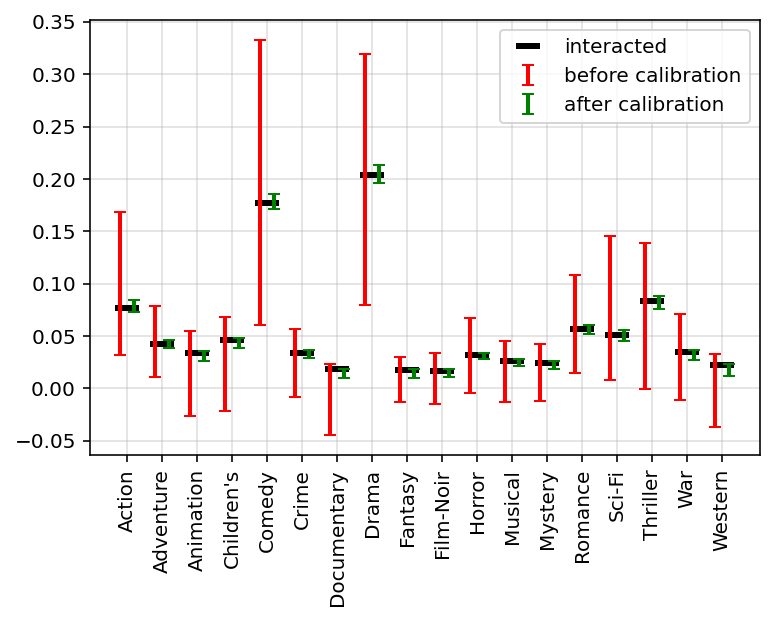

In [101]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

info_table_final = final_averaged_table.fillna(0)

info_table_final = info_table_final.sort_index()

n = info_table_final.shape[0]
index = np.arange(n)

plt.plot(index, info_table_final['inter_distr'], '_',
    ms=12.0, mew=3.0, mec='k', label='interacted')

pre_yerr = [
    -np.array(info_table_final['neg_pre_delta'].to_list()),
    np.array(info_table_final['pos_pre_delta'].to_list())
]
post_yerr = [
    -np.array(info_table_final['neg_post_delta'].to_list()),
    np.array(info_table_final['pos_post_delta'].to_list())
]

plt.errorbar(index - 0.2, info_table_final['inter_distr'], yerr=pre_yerr,
    fmt=' ', lw=2, capsize=3, label='before calibration', ecolor='r')
plt.errorbar(index + 0.2, info_table_final['inter_distr'], yerr=post_yerr,
    fmt=' ', lw=2, capsize=3, label='after calibration', ecolor='g')

plt.legend()

plt.xticks(index, info_table_final.index, rotation=90)
plt.grid(alpha=0.4)

plt.savefig(save_path + prefix + 'average_table.png', bbox_inches='tight', dpi=300)
plt.savefig(save_path + prefix + 'average_table.pdf', bbox_inches='tight')
plt.show()

The averaged table is saved to disk with the formatted name containing the experiment, model, topk and lambda as the prefix. This is saved to the results folder, unless changed.

In [102]:
info_table_final.sort_index().fillna(0)

,inter_distr,recom_distr,calib_distr,neg_pre_delta,pos_pre_delta,neg_post_delta,pos_post_delta
Action,0.077256,0.107113,0.080342,-0.045441,0.091134,-0.004558,0.006926
Adventure,0.042786,0.049361,0.043859,-0.031456,0.035907,-0.004094,0.003787
Animation,0.034025,0.016836,0.032116,-0.060037,0.021093,-0.007459,0.001363
Children's,0.046460,0.018118,0.044401,-0.068249,0.021689,-0.007597,0.001959
Comedy,0.177508,0.196810,0.181265,-0.116683,0.155288,-0.005822,0.007729
Crime,0.034295,0.027764,0.033483,-0.042488,0.022537,-0.005311,0.002259
Documentary,0.018161,0.004719,0.017053,-0.062816,0.004807,-0.008376,0.000601
Drama,0.204076,0.210517,0.208796,-0.124232,0.115665,-0.007791,0.009077
Fantasy,0.017440,0.012633,0.016131,-0.030053,0.012422,-0.007055,0.001308
Film-Noir,0.017053,0.015602,0.015673,-0.031839,0.016462,-0.006550,0.001086


In [103]:
info_table_final.sort_index().fillna(0).to_csv(
    save_path + prefix + 'average_table.csv'
)

Here, it selects the user with the worst calibration metric, and generates the plot containing the 3 distributions for each genre.

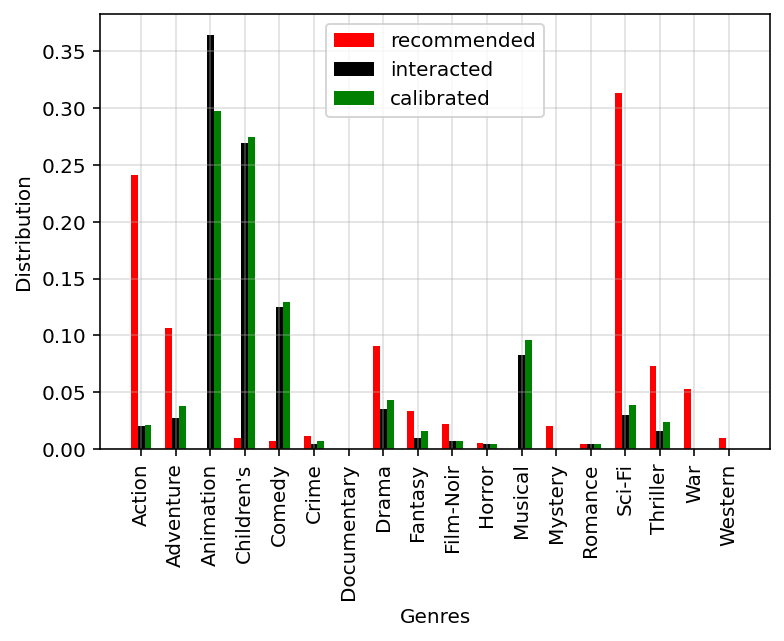

In [104]:
user_id = worst_case[0]

df = pd.DataFrame({
    'recommended': distr_dict['recom_distr'][user_id],
    'interacted': distr_dict['inter_distr'][user_id],
    'calibrated': distr_dict['calib_distr'][user_id]
})

n = df.shape[0]
index = np.arange(n)

plt.bar(index - 0.2, df['recommended'], width=0.2, label='recommended', color='r')
plt.bar(index, df['interacted'], width=0.2, label='interacted', color='k')
plt.bar(index + 0.2, df['calibrated'], width=0.2, label='calibrated', color='g')

plt.xticks(index, df.index, rotation=90)
plt.legend()
plt.grid(True, alpha=0.4)

plt.xlabel('Genres')
plt.ylabel('Distribution')

plt.savefig(save_path + prefix + 'single_table.png', bbox_inches='tight', dpi=300)
plt.savefig(save_path + prefix + 'single_table.pdf', bbox_inches='tight')
plt.show()

Here, it generates some extra deltas and saves the file to disk.

In [105]:
df['pre_delta'] = df['recommended'] - df['interacted']
df['post_delta'] = df['calibrated'] - df['interacted']
df['recom_delta'] = df['calibrated'] - df['recommended']

df.sort_index().fillna(0)

,recommended,interacted,calibrated,pre_delta,post_delta,recom_delta
Action,0.241333,0.020667,0.021333,0.220667,0.000667,-0.220000
Adventure,0.106333,0.027333,0.038000,0.079000,0.010667,-0.068333
Animation,0.000000,0.364667,0.298000,-0.364667,-0.066667,0.298000
Children's,0.010000,0.269667,0.274667,-0.259667,0.005000,0.264667
Comedy,0.006667,0.125333,0.129667,-0.118667,0.004333,0.123000
Crime,0.011667,0.004000,0.006667,0.007667,0.002667,-0.005000
Documentary,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Drama,0.090667,0.035000,0.043333,0.055667,0.008333,-0.047333
Fantasy,0.033333,0.010000,0.015667,0.023333,0.005667,-0.017667
Film-Noir,0.021667,0.006667,0.006667,0.015000,0.000000,-0.015000


In [106]:
df.sort_index().fillna(0).to_csv(
    save_path + prefix + 'single_table.csv'
)